In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [79]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [80]:
df_solar_satellite = pd.read_csv('../../1_data_analysis_and_preproc/intermediate/solar/df_solar_satellite.csv')

In [81]:
df_solar_satellite.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,global_tilted_irradiance,global_horizontal_irradiance,temperature,cloud_cover
0,11,2022-01-01 08:10:00,60.6247,275.567,0.220,2.0,2.0,12.3,46.1
1,11,2022-01-01 08:20:00,157.1340,301.600,0.521,9.0,9.0,12.4,56.1
2,11,2022-01-01 08:30:00,297.7330,313.733,0.949,52.0,29.0,12.6,37.2
3,11,2022-01-01 08:40:00,645.5820,323.600,1.995,126.0,55.0,12.7,12.5
4,11,2022-01-01 08:50:00,617.0240,321.367,1.920,235.0,83.0,12.9,3.0


In [82]:
np.random.seed(10)

asset = df_solar_satellite['asset_id'].unique()[0]

length = len(df_solar_satellite[df_solar_satellite['asset_id'] == asset])

subset_size = int(0.015 * length)  # Adjust the percentage as needed

# Group the DataFrame by the asset identifier column(s)
grouped = df_solar_satellite.groupby('asset_id')

# Initialize an empty list to store the sampled data
subset_data = []

# Iterate over each group, sample subset_size rows from each group, and append to subset_data
for _, group_df in grouped:
    sampled_group = group_df.sample(n=subset_size, replace=False)
    subset_data.append(sampled_group)

# Concatenate the sampled data from all groups into a single DataFrame
df_subset = pd.concat(subset_data)

In [83]:
len(df_subset)

48587

In [84]:
df_subset = df_subset.reset_index(drop=True)

the variables to include for the model should be dc_power, dc_voltage, dc_current, temperature and cloud_cover, as global_tilted_irradiance and global_horizontal_irradiance have very high correlation with other variables and keeping them, would be reductant

however, in the time series clustering, we'll want to do one variable at a time and then all of them.

In [85]:
X = df_subset[['asset_id','read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']]
X.head()

,asset_id,read_at,dc_power,dc_voltage,dc_current,temperature,cloud_cover
0,11,2022-09-01 07:10:00,311.415,301.467,1.033,15.0,0.0
1,11,2022-05-11 14:30:00,5503.840,281.800,19.531,24.7,0.0
2,11,2022-04-22 15:40:00,1046.530,326.633,3.204,10.9,52.8
3,11,2022-05-04 09:20:00,4640.730,296.400,15.657,19.5,0.0
4,11,2023-01-18 16:10:00,628.495,313.933,2.002,9.0,20.0


In [86]:
X.dtypes

asset_id         int64
read_at         object
dc_power       float64
dc_voltage     float64
dc_current     float64
temperature    float64
cloud_cover    float64
dtype: object

In [87]:
X['read_at'] = pd.to_datetime(X['read_at'])

/tmp/ipykernel_70748/2166665197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = pd.to_datetime(X['read_at'])


In [88]:
X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)

/tmp/ipykernel_70748/3417196857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['read_at'] = X['read_at'].apply(pd.Timestamp.timestamp).values.reshape(-1, 1)


In [89]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48587 entries, 0 to 48586
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     48587 non-null  int64  
 1   read_at      48587 non-null  float64
 2   dc_power     48587 non-null  float64
 3   dc_voltage   48587 non-null  float64
 4   dc_current   48587 non-null  float64
 5   temperature  48587 non-null  float64
 6   cloud_cover  48587 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 2.6 MB


In [90]:
X = X.astype(np.float32)

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48587 entries, 0 to 48586
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   asset_id     48587 non-null  float32
 1   read_at      48587 non-null  float32
 2   dc_power     48587 non-null  float32
 3   dc_voltage   48587 non-null  float32
 4   dc_current   48587 non-null  float32
 5   temperature  48587 non-null  float32
 6   cloud_cover  48587 non-null  float32
dtypes: float32(7)
memory usage: 1.3 MB


In [92]:
X_grouped = X.groupby('asset_id')

In [114]:
def zoom_in_plot(X_train, y_pred, km, sz, title:str):
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(3, 4, width_ratios=[5, 1, 3, 1], height_ratios=[1, 1, 1])

    for yi in range(3):
        # Main plot with more width
        ax = plt.subplot(gs[yi, 0])
        for xx in X_train[y_pred == yi]:  
            ax.plot(xx.ravel(), "k-", alpha=0.2)
        ax.plot(km.cluster_centers_[yi].ravel(), "r-")
        ax.set_xlim(0, sz)
        ax.set_ylim(-4, 4)
        ax.text(0.55, 0.85, 'Cluster %d' % (yi + 1), transform=ax.transAxes)
        if yi == 0:
            ax.set_title(f"{title} $k$-means")

        # Zoomed-in plot
        axins = plt.subplot(gs[yi, 2])
        for xx in X_train[y_pred == yi]:  
            axins.plot(xx.ravel(), "k-", alpha=0.2)
        axins.plot(km.cluster_centers_[yi].ravel(), "r-")
        axins.set_xlim(200, 220)
        axins.set_ylim(-3, 3)
        mark_inset(ax, axins, loc1=2, loc2=3, fc="None", ec="g")

    # Adjust spacing between the two plots in the same row
    plt.subplots_adjust(wspace=0)

    # plt.tight_layout()
    plt.show()

## Time Series Clustering with all important variables

https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html#sphx-glr-auto-examples-clustering-plot-kmeans-py

### Euclidean k-Means

In [94]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

In [95]:
X_train = X.loc[:,'read_at':]

In [97]:
# Define the parameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5, 10],
}

euc_k_means_clust = TimeSeriesKMeans(verbose=False, random_state=seed)

# Initialize GridSearchCV
grid_search = GridSearchCV(euc_k_means_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(X_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[CV] END .......................................n_clusters=2; total time=  57.9s
[CV] END .......................................n_clusters=2; total time=  58.8s
[CV] END .......................................n_clusters=3; total time= 2.1min
[CV] END .......................................n_clusters=3; total time= 2.1min
[CV] END .......................................n_clusters=4; total time= 2.4min
[CV] END .......................................n_clusters=5; total time= 2.5min
[CV] END .......................................n_clusters=4; total time= 2.5min
[CV] END .......................................n_clusters=5; total time= 2.6min
[CV] END ......................................n_clusters=10; total time= 2.3min
[CV] END ......................................n_clusters=10; total time= 2.4min


GridSearchCV(cv=2, estimator=TimeSeriesKMeans(random_state=42, verbose=False),
             n_jobs=-1, param_grid={'n_clusters': [2, 3, 4, 5, 10]},
             scoring=<function clustering_score at 0x7f2b1a699620>, verbose=2)

In [98]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,23.409657,5.042078,34.921430,5.522118,2,{'n_clusters': 2},0.563835,0.563817,0.563826,0.000009,1
1,57.778801,36.862781,66.240698,37.241670,3,{'n_clusters': 3},0.544598,0.543472,0.544035,0.000563,2
2,74.969770,0.237612,72.073804,2.910519,4,{'n_clusters': 4},0.540028,0.540411,0.540219,0.000192,4
3,80.051768,15.116714,73.836881,10.458794,5,{'n_clusters': 5},0.542851,0.545155,0.544003,0.001152,3
4,86.630199,14.551147,53.647723,13.662885,10,{'n_clusters': 10},0.530074,0.530163,0.530119,0.000045,5


In [99]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Clustering Score:", best_score)

Best Parameters: {'n_clusters': 2}
Best Clustering Score: 0.5638259133946879


In [100]:
# Grouping by 'asset_id' and storing each group as an array
grouped_arrays_all = [group[['read_at', 'dc_power', 'dc_voltage', 'dc_current', 'temperature', 'cloud_cover']].values \
                    for _, group in X.groupby('asset_id')]

In [122]:
X_train = grouped_arrays_all

In [102]:
seed = 42

In [126]:
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train)

sz = X_train.shape[1]

using 3 clusters as its the second best clustering partition and then the can be more distributed

Euclidean k-means
7126.556 --> 3628.095 --> 3628.095 --> 


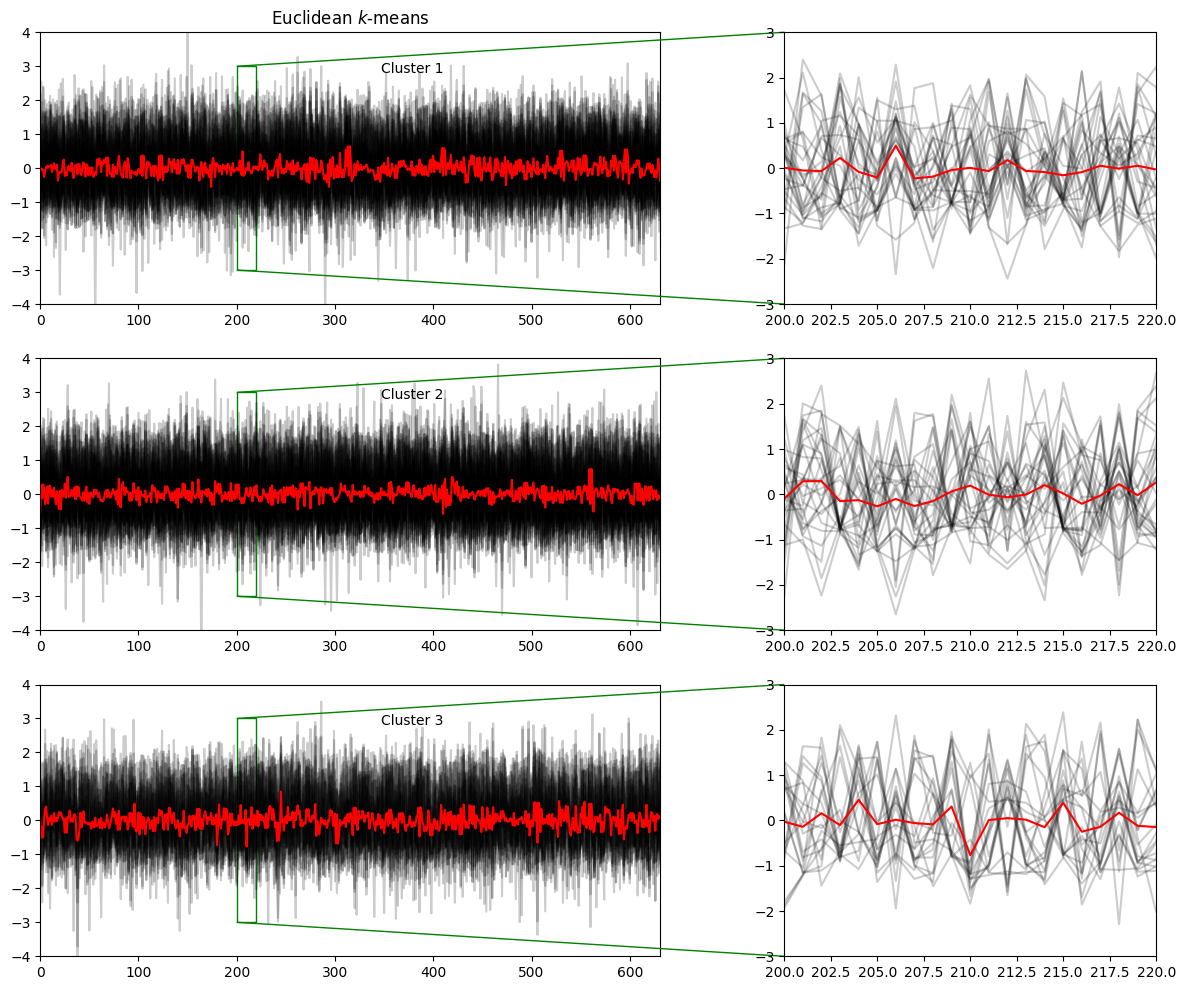

In [115]:
# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=3, verbose=True, random_state=seed)
y_pred_euclidean = km.fit_predict(X_train)

zoom_in_plot(X_train, y_pred_euclidean, km, sz, 'Euclidean')


In [116]:
assets_per_cluster_euclidean = pd.DataFrame()

assets_per_cluster_euclidean['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_euclidean['cluster_label'] = y_pred_euclidean

In [117]:
assets_clusters = assets_per_cluster_euclidean.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 5, 10, 18, 20, 26, 28, 34, 36, 42, 43, 45, 46, 47, 49, 52, 53, 54, 57, 58, 62, 63, 64, 68, 69, 70, 72, 75]
Cluster 1: [1, 3, 7, 8, 9, 11, 13, 14, 15, 17, 21, 23, 24, 29, 30, 31, 32, 33, 37, 38, 40, 48, 51, 55, 56, 61, 65, 71, 73]
Cluster 2: [2, 4, 6, 12, 16, 19, 22, 25, 27, 35, 39, 41, 44, 50, 59, 60, 66, 67, 74, 76]


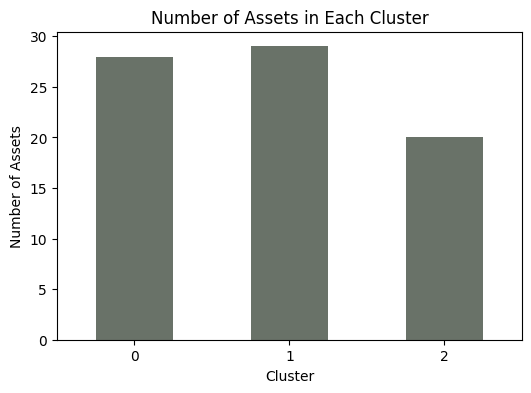

In [118]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_euclidean['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### DBA k-Means

In [123]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)

y_pred_DBA = dba_km.fit_predict(X_train)

DBA k-means
Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


70370888852174632.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


51488609884484232.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


51230304075647368.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


51230304075647368.000 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


68643315709621264.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


49122200037992488.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


49113764495004528.000 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


49113764495004528.000 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.5s


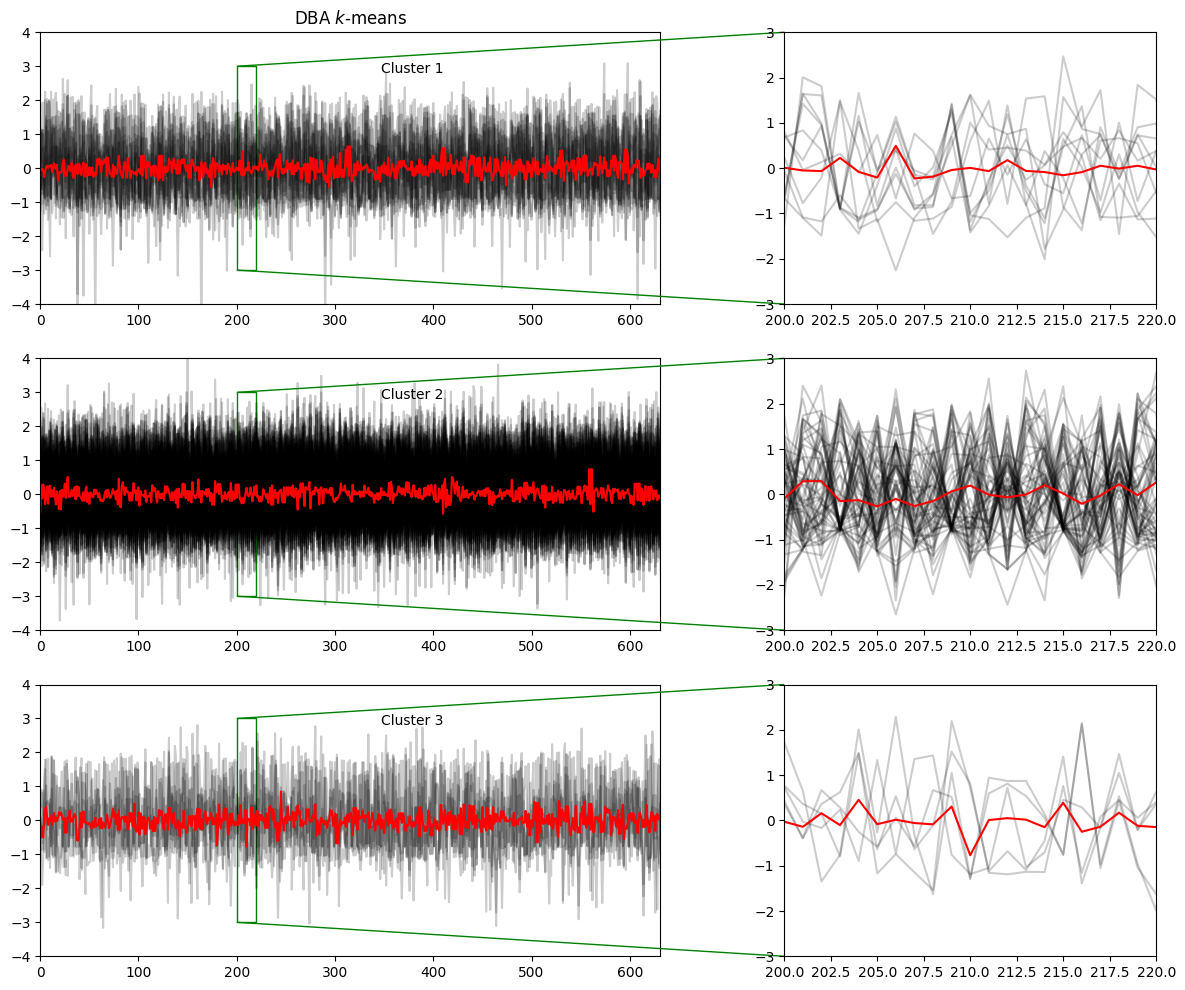

In [127]:
zoom_in_plot(X_train, y_pred_DBA, km, sz, 'DBA')

In [128]:
assets_per_cluster_dba = pd.DataFrame()

assets_per_cluster_dba['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_dba['cluster_label'] = y_pred_DBA

In [129]:
assets_clusters = assets_per_cluster_dba.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [23, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Cluster 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 2: [72, 73, 74, 75, 76]


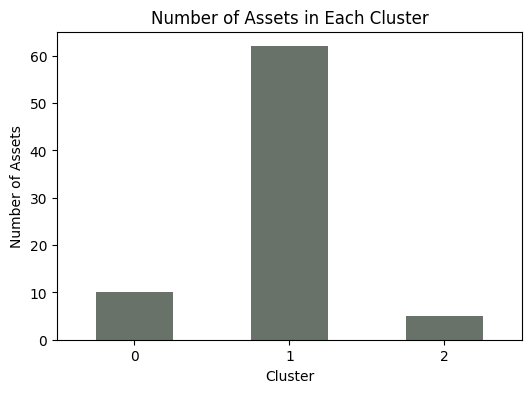

In [130]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_dba['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

## Soft DTW k-means

In [ ]:
# Soft-DTW-k-means
print("Soft-DTW k-means")
sdtw_km = TimeSeriesKMeans(n_clusters=3,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
                           
y_pred_soft_dtw = sdtw_km.fit_predict(X_train)

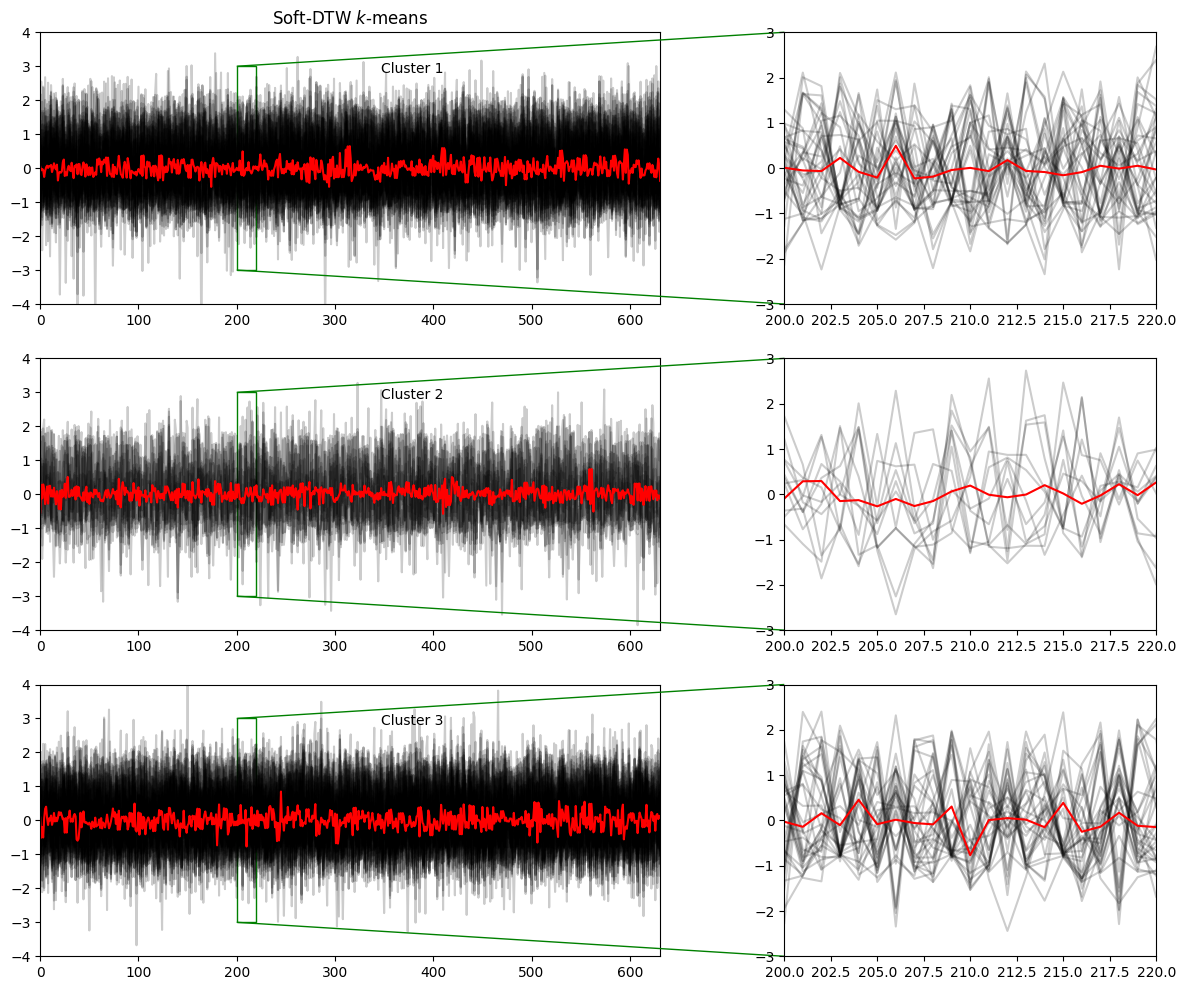

In [133]:
zoom_in_plot(X_train, y_pred_soft_dtw, km, sz, 'Soft-DTW')

In [134]:
assets_per_cluster_soft_dtw = pd.DataFrame()

assets_per_cluster_soft_dtw['asset_id'] = df_subset['asset_id'].unique()
assets_per_cluster_soft_dtw['cluster_label'] = y_pred_soft_dtw

In [135]:
assets_clusters = assets_per_cluster_soft_dtw.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 2, 3, 10, 12, 24, 26, 28, 29, 30, 33, 34, 35, 36, 39, 40, 41, 42, 43, 48, 49, 51, 52, 53, 55, 57, 59, 60, 65, 66, 67, 68, 70]
Cluster 1: [19, 31, 32, 37, 38, 56, 72, 73, 74, 75, 76]
Cluster 2: [1, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 27, 44, 45, 46, 47, 50, 54, 58, 61, 62, 63, 64, 69, 71]


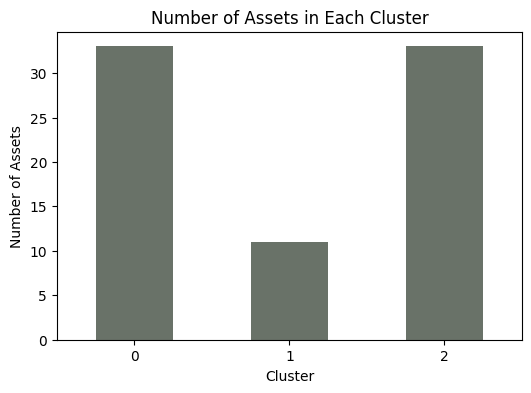

In [136]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_per_cluster_soft_dtw['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()